# Levenberg-Marquard

In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [2]:
# Libraries required for Levenberg-Marquard implementation

from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

## 1. SIRD ODEs Definition

In [3]:
# ODE function: SIRD ODEs definition
def ODE(xs, t, ps):
    """SIRD model"""
    try:
        mu = ps['mu'].value
        beta = ps['beta'].value
        gamma = ps['gamma'].value
    except:
        mu, beta, gamma = ps

    S, I, R, D = xs
    N = ps['N0'].value
    return [-beta*((I*S)/N), beta*((I*S)/N) - ((gamma)*I) - (mu*I), (gamma)*I, mu*I]

## 2. SIRD ODEs Resolution

In [4]:
# Function of the resolution of the ODEs, starting from an initial condition
def g(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(ODE, x0, t, args=(ps,))
    return x

## 3. Residual Function to minimise

In [5]:
# Residual error function (function to be minimised)
def residual(ps, ts, data):
    x0 = ps['S0'].value, ps['I0'].value, ps['R0'].value, ps['D0'].value
    model = g(ts, x0, ps)
    return ((model - data)).ravel()

## 4. Definition of the data and parameters

In [6]:
# Reading of the file
df = pd.read_csv('SIRD(Raw)_Spain.csv')

# Arrays Definition
dates = df.values[:, 3]
S_total = df.values[:,4]
I_total = df.values[:,5]
R_total = df.values[:,6]
D_total = df.values[:,7]
N_total = df.values[:,8]
N_no_deaths = df.values[:,9]

# Joint array of SIRD data
columns = 4  # Number of columns
SIRD_total = np.empty((len(S_total), columns), dtype = float)

for i in range(len(S_total)):
    SIRD_total[i] = [S_total[i], I_total[i], R_total[i], D_total[i]]
    
SIRD_total.shape, SIRD_total[600:620]

((787, 4),
 array([[4.2318e+07, 5.0803e+04, 4.8758e+06, 8.7703e+04],
        [4.2312e+07, 4.7449e+04, 4.8850e+06, 8.7821e+04],
        [4.2310e+07, 4.4427e+04, 4.8904e+06, 8.7903e+04],
        [4.2307e+07, 4.1628e+04, 4.8959e+06, 8.8005e+04],
        [4.2304e+07, 3.9867e+04, 4.9006e+06, 8.8105e+04],
        [4.2301e+07, 3.8201e+04, 4.9050e+06, 8.8149e+04],
        [4.2301e+07, 3.8201e+04, 4.9050e+06, 8.8149e+04],
        [4.2301e+07, 3.8201e+04, 4.9050e+06, 8.8149e+04],
        [4.2296e+07, 3.5470e+04, 4.9127e+06, 8.8218e+04],
        [4.2294e+07, 3.4594e+04, 4.9158e+06, 8.8278e+04],
        [4.2291e+07, 3.3683e+04, 4.9194e+06, 8.8317e+04],
        [4.2289e+07, 3.2091e+04, 4.9234e+06, 8.8335e+04],
        [4.2287e+07, 3.0902e+04, 4.9266e+06, 8.8383e+04],
        [4.2287e+07, 3.0902e+04, 4.9266e+06, 8.8383e+04],
        [4.2287e+07, 3.0902e+04, 4.9266e+06, 8.8383e+04],
        [4.2282e+07, 2.9239e+04, 4.9325e+06, 8.8447e+04],
        [4.2281e+07, 2.8578e+04, 4.9348e+06, 8.8541e+04],
   

In [7]:
# Time interval  (7 days)
t = np.linspace(0, 6, 7)

## 5. Application of the Levenberg-Marquardt algorithm to the dataset

In [8]:
# Arrays of the parameters to be estimated
beta_fin = np.empty(len(SIRD_total)-6, dtype = float)
mu_fin = np.empty(len(SIRD_total)-6, dtype = float)
gamma_fin = np.empty(len(SIRD_total)-6, dtype = float)

# For loop to estimate each time-dependant parameter (from initial time to final time minus 6)
# 6 last values are lost because of the 7-day resolution applied to solve this method
for i in range(0, len(SIRD_total)-6):

    # SIRD data for 7 days: estimate a parameter for 7 days SIRD data values
    data = SIRD_total[i:i+7]
    
    # Set parameters incluing bounds
    params = Parameters()
    params.add('S0', value=S_total[i], vary = False)
    params.add('I0', value=I_total[i], vary = False)
    params.add('R0', value=R_total[i], vary = False)
    params.add('D0', value=D_total[i], vary = False)
    params.add('N0', value=N_no_deaths[i], vary = False)
    params.add('mu', value=0.010)
    params.add('beta', value=0.045)
    params.add('gamma', value=1/14, vary = True)

    # Fit model and find predicted values
    result = minimize(residual, params, args=(t, data), method='leastsq', max_nfev=10000)
    
    # Saving the results in the vectors
    a = result.params
    beta_fin[i] = a['beta'].value
    mu_fin[i] = a['mu'].value
    gamma_fin[i] = a['gamma'].value
    
    # Restarting the parameters for next loop cycle
    del params

In [9]:
# Final beta length and values
beta_fin.shape, beta_fin

((781,),
 array([ 0.045 ,  0.045 ,  0.045 ,  0.045 ,  0.0136,  0.0136,  0.0723,
         0.0987,  0.1234,  0.14  ,  0.1511,  0.1567,  0.045 ,  0.0206,
         0.0116,  0.0148,  0.0047, -0.013 ,  0.0337,  0.0337,  0.0293,
         0.0133,  0.2156,  0.3494,  0.4541,  0.5897,  0.045 ,  0.045 ,
         0.5678,  0.4568,  0.4905,  0.3727,  0.3768,  0.3077,  0.2941,
         0.3063,  0.3314,  0.3729,  0.3234,  0.3826,  0.3937,  0.3565,
         0.3158,  0.3012,  0.3419,  0.2131,  0.2096,  0.21  ,  0.1937,
         0.1985,  0.1976,  0.1817,  0.1928,  0.1805,  0.1857,  0.1682,
         0.1661,  0.1378,  0.122 ,  0.1138,  0.1065,  0.1026,  0.0948,
         0.0862,  0.077 ,  0.0703,  0.0654,  0.0615,  0.0611,  0.0619,
         0.0603,  0.0553,  0.0544,  0.0556,  0.0589,  0.0626,  0.0712,
         0.0808,  0.0789,  0.0666,  0.0604,  0.0731,  0.0559,  0.0628,
         0.0562,  0.0464,  0.0336,  0.0446,  0.0395,  0.04  ,  0.0393,
         0.0399,  0.035 ,  0.0453,  0.0439,  0.043 ,  0.0524,  0.061

In [10]:
# Final mu and gamma length
mu_fin.shape, gamma_fin.shape

((781,), (781,))

In [11]:
# Example of the last full output of the method
result

## 6. Collection and manipulation of the results

In [12]:
# Gamma Fixed (No negatives)
gamma_raw_fix = np.empty(len(gamma_fin), dtype = object)

for i in range(0, len(gamma_fin)):
    if gamma_fin[i] >= 0:
        gamma_raw_fix[i] = gamma_fin[i]
    if gamma_fin[i] < 0:
        gamma_raw_fix[i] = 0

gamma_raw_fix.shape, gamma_raw_fix

((781,),
 array([0.07142857142857142, 0.07142857142857142, 0.07142857142857142,
        0.07142857142857142, 0.004974135326094623, 0.004974135326094623, 0,
        0, 0, 0, 0, 0.014239712041831583, 0.07142857142857142,
        0.08505679737560148, 0.09974851392416177, 0.13550695199200416,
        0.1645258508058572, 0.18891373297035033, 0.018357244034394725,
        0.018357244034394725, 0.08297003476659208, 0.15212264231306488,
        0.12120155067236218, 0.007284652739237448, 0.0354372867186765,
        0.030648627592008818, 0.07142857142857142, 0.07142857142857142, 0,
        0, 0.0010489371236902067, 0.0022429620165527013,
        0.0002993969059759058, 0.0004021722376829614,
        2.0226539905849198e-05, 0, 0, 0.0012791186712759047,
        0.0030554201275218625, 0.000679653440238796, 0.003090102374277917,
        0.004954786200856142, 0.005072632662766378, 0.006165170161153787,
        0.009464083691022938, 0.0039883188485281065, 0.004944374783776259,
        0.004850491123685

In [13]:
# Calulate gamma smooth (6 first values are lost)
gamma_smooth = np.empty(len(gamma_fin)-6, dtype = object)
gamma_smooth_fix = np.empty(len(gamma_fin)-6, dtype = object)

for i in range(0, len(gamma_fin)-6):
    sum_g = 0
    sum_g_f = 0
    for j in range(i, i+7):
        sum_g = sum_g + gamma_fin[j]
        sum_g_f = sum_g_f + gamma_raw_fix[j]
    gamma_smooth[i] = (sum_g/7)
    gamma_smooth_fix[i] = (sum_g_f/7)

gamma_smooth.shape, gamma_smooth

((775,),
 array([0.039652678845496496, 0.026831811217170175, 0.015204273990672906,
        0.003901009334897262, -0.008355105534802261, -0.007031451718268411,
        0.00246203915351399, 0.01719783941402842, 0.03406441311315335,
        0.05484600470585529, 0.0794488807012432, 0.10848859007691113,
        0.10907680893299157, 0.1014951907338235, 0.10119708178967927,
        0.10867910013095115, 0.1066354713710023, 0.0841724430757709,
        0.06224723646838893, 0.06400314840519096, 0.07158476660435906,
        0.06993598612749896, 0.04729472983198651, 0.029767318199106364,
        0.028876501682599615, 0.024134455296581928, 0.01979885091286294,
        0.009652222457021733, -0.0005489696699304923,
        0.00026654861560419015, 0.0003584110822381074,
        0.0003912941604646356, 0.0005073596048888015,
        0.0005616819669263573, 0.0009456719864399224,
        0.0016506090808613928, 0.0024692028550822288,
        0.0034709833768701123, 0.004640264093976831, 0.004773535339834866,

Text(0.5, 1.0, 'Gamma Estimated')

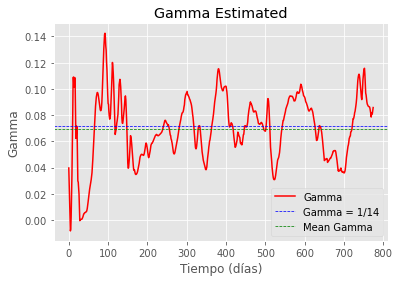

In [14]:
# Gamma Not Fixed Representation

plt.plot(range(0, len(gamma_smooth)), gamma_smooth, 'r', label="Gamma")
plt.axhline(y=1/14, color='b', linestyle='--', linewidth = 0.75, label="Gamma = 1/14")
plt.axhline(y=np.mean(gamma_smooth), color='g', linestyle='--', linewidth = 0.75, label="Mean Gamma")
plt.xlabel("Tiempo (días)")
plt.ylabel("Gamma")
plt.legend()

plt.title("Gamma Estimated")

Text(0.5, 1.0, 'Gamma Estimated Fix')

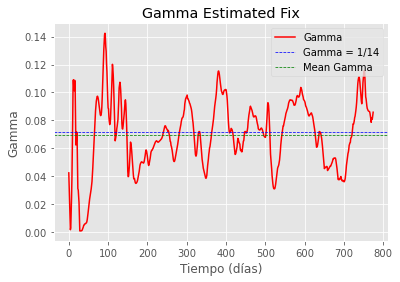

In [15]:
# Gamma Fixed Representation

plt.plot(range(0, len(gamma_smooth_fix)), gamma_smooth_fix, 'r', label="Gamma")
plt.axhline(y=1/14, color='b', linestyle='--', linewidth = 0.75, label="Gamma = 1/14")
plt.axhline(y=np.mean(gamma_smooth_fix), color='g', linestyle='--', linewidth = 0.75, label="Mean Gamma")
plt.xlabel("Tiempo (días)")
plt.ylabel("Gamma")
plt.legend()

plt.title("Gamma Estimated Fix")

In [16]:
# Estimating beta parameters (6 first values are lost)
beta_smooth = np.empty(len(beta_fin)-6, dtype = object)

for i in range(0, len(beta_fin)-6):
    sum_b = 0
    for j in range(i, i+7):
        sum_b = sum_b + beta_fin[j]
    beta_smooth[i] = (sum_b/7)

beta_smooth.shape, beta_smooth

((775,),
 array([0.03994075670148489, 0.047611134324488394, 0.05880913621305865,
        0.072382952423151, 0.08753341026843138, 0.10797843267251918,
        0.1124610155478333, 0.10506739867870554, 0.09262215924487492,
        0.07710662463266042, 0.057774752032156186, 0.03433427493838186,
        0.01675156248450779, 0.015131289559407396, 0.016371319089819907,
        0.016621649500145764, 0.045309476030846, 0.09454721019495411,
        0.16128098140374503, 0.240715748945277, 0.2423360218703774,
        0.2445836867569795, 0.3237882033458912, 0.35824380448902,
        0.378404607319282, 0.36677348328368115, 0.3363592558675667,
        0.3738882715387466, 0.40947244487648743, 0.3721192369056045,
        0.3542122670450107, 0.3374210832004426, 0.3303835904719092,
        0.3312075177502089, 0.34348681702174544, 0.352403326513552,
        0.3537598661569774, 0.34944189173383283, 0.3450125779854967,
        0.3292505575644909, 0.3045439475076295, 0.27830177061655176,
        0.2550510539

Text(0.5, 1.0, 'Beta Estimated')

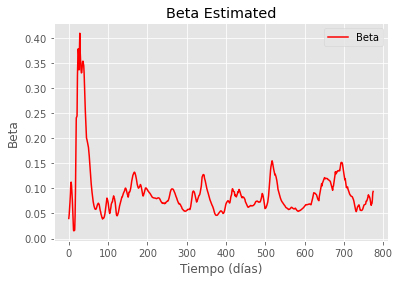

In [17]:
# Beta Representation

plt.plot(range(0, len(beta_smooth)), beta_smooth, 'r', label="Beta")
plt.xlabel("Tiempo (días)")
plt.ylabel("Beta")
plt.legend()

plt.title("Beta Estimated")

In [18]:
# Estimating reproduction rate R0
R0_raw = np.empty(len(beta_smooth), dtype = object)
R0_smooth_gammaMean = np.empty(len(beta_smooth), dtype = object)
R0_smooth_constant = np.empty(len(beta_smooth), dtype = object)

for i in range (0, len(R0_raw)):
    R0_raw[i] = beta_fin[i]/(np.mean(gamma_fin))
    R0_smooth_gammaMean[i] = beta_smooth[i]/(np.mean(gamma_smooth))
    R0_smooth_constant[i] = beta_smooth[i]/(1/14)
    
R0_smooth_gammaMean.shape, R0_smooth_gammaMean

((775,),
 array([0.574838134167497, 0.6852322760241917, 0.8463969369779117,
        1.0417549579102474, 1.2598044301487268, 1.55405470236106,
        1.6185692431234024, 1.5121583166213333, 1.3330430767955193,
        1.1097393213420075, 0.8315098010879639, 0.4941481377301879,
        0.241093001691345, 0.21777359710249317, 0.23562043628239343,
        0.23922325900987945, 0.6521061895832868, 1.3607489288551462,
        2.3211993483184266, 3.4644459298211125, 3.487765334409964,
        3.520114333185947, 4.6600470809277015, 5.155941378093065,
        5.446101085603957, 5.278702813987162, 4.840973056619416,
        5.381100763933529, 5.893237776265076, 5.35564034075243,
        5.0979184047312565, 4.85625516174828, 4.754969669850298,
        4.766827853281508, 4.943554837572017, 5.071883645107261,
        5.091407329232202, 5.029261877674166, 4.965514000542902,
        4.738662754903279, 4.38307856472788, 4.005394082851258,
        3.670763503287668, 3.429668912734294, 3.216596041285507

Text(0.5, 1.0, 'R0 with Gamma = 1/14')

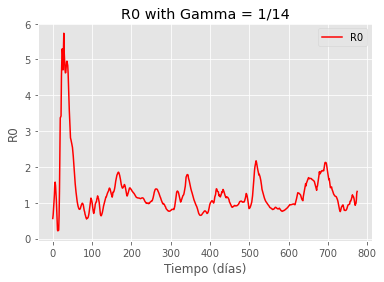

In [19]:
# R0 Representation with Gamma = 1/14

plt.plot(range(0, len(R0_smooth_constant)), R0_smooth_constant, 'r', label="R0")
plt.xlabel("Tiempo (días)")
plt.ylabel("R0")
plt.legend()

plt.title("R0 with Gamma = 1/14")

Text(0.5, 1.0, 'R0 with Mean Gamma')

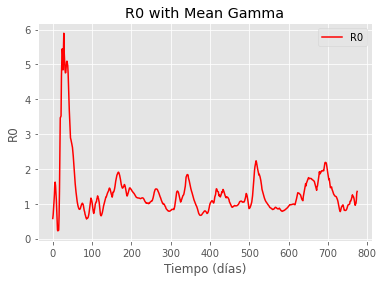

In [20]:
# R0 Representation with Mean Gamma

plt.plot(range(0, len(R0_smooth_gammaMean)), R0_smooth_gammaMean, 'r', label="R0")
plt.xlabel("Tiempo (días)")
plt.ylabel("R0")
plt.legend()

plt.title("R0 with Mean Gamma")

In [21]:
# Mu Fixed (No negatives)
mu_fixed = np.empty(len(mu_fin), dtype = object)

for i in range(0, len(mu_fin)):
    if mu_fin[i] >= 0:
        mu_fixed[i] = mu_fin[i]
    if mu_fin[i] < 0:
        mu_fixed[i] = 0

mu_fixed.shape, mu_fixed

((781,),
 array([0.01, 0.01, 0.01, 0.01, 0.00755949434704741, 0.00755949434704741,
        0.01989606483542372, 0.014102559927569812, 0.009344733056350895,
        0.012119885504193025, 0.03062086364692349, 0.0029263127156607324,
        0.01, 0.005102515447594363, 0.009572721657408818,
        0.007260646258530502, 0.006986164442707001, 0.0002481341097484807,
        0.016107294163304166, 0.016107294163304166, 0.01243118633694377, 0,
        0, 0, 0, 0.0009554186366966459, 0.01, 0.01, 0,
        0.0010566921073620382, 0.00597471215127179, 0,
        0.005489856502185114, 0.006165656378668331, 0.008264498898064767,
        0.006701891005824436, 0.004996581199362277, 0.009043750655629911,
        0.010962823058954992, 0.008451290947795958, 0.011415590779604301,
        0.013476331519409909, 0.012908719354098458, 0.01521435772510989,
        0.02028612036357373, 0.01174049894741347, 0.012407705093675914,
        0.012596878870778115, 0.013919395120229034, 0.01429536849023002,
        0.0

In [22]:
# Estimating mu parameters (6 first values are lost)
mu_smooth_fix = np.empty(len(mu_fixed)-6, dtype = object)
mu_smooth = np.empty(len(mu_fin)-6, dtype = object)

for i in range(0, len(mu_fixed)-6):
    sum_b_fix = 0
    sum_b = 0
    for j in range(i, i+7):
        sum_b_fix = sum_b_fix + mu_fixed[j]
        sum_b = sum_b + mu_fin[j]
    mu_smooth_fix[i] = (sum_b_fix/7)
    mu_smooth[i] = (sum_b/7)

mu_smooth.shape, mu_smooth

((775,),
 array([0.010716436218502648, 0.01130251620815548, 0.011208906644777033,
        0.011511747431090322, 0.014457585094936538, 0.01379570200473844,
        0.014144345669445951, 0.012030981471184615, 0.011383861718304475,
        0.011086135032901562, 0.010352746309832128, 0.006013784947378556,
        0.007896782297041905, 0.008769252891799643, 0.009816205875992415,
        0.008234803803872422, 0.005201103886674441, 0.0014358519100147232,
        -0.0009079903844754152, -0.0030725440311336317,
        -0.00394501462589137, -0.00429232695974048, -0.004100402863842412,
        -0.001952982111097069, 0.0016677766810719052, 0.003939404014020437,
        0.004587180851947361, 0.004039417477471409, 0.0037914887486235186,
        0.004770848060333387, 0.005333689359190564, 0.005772123431241725,
        0.007375008242669976, 0.007798070306328668, 0.008548060935033807,
        0.009292608452368827, 0.010179298216407973, 0.01163898057722906,
        0.013245033392649605, 0.0133561299481

Text(0.5, 1.0, 'Mu Estimated (Not Fixed)')

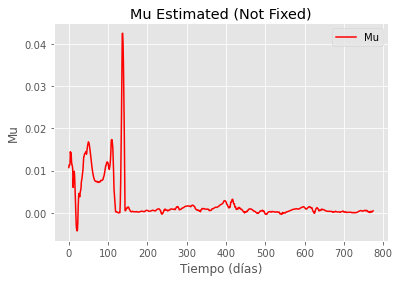

In [23]:
# Mu Not Fixed Representation

plt.plot(range(0, len(mu_smooth)), mu_smooth, 'r', label="Mu")
plt.xlabel("Tiempo (días)")
plt.ylabel("Mu")
plt.legend()

plt.title("Mu Estimated (Not Fixed)")

Text(0.5, 1.0, 'Mu Estimated (Fixed)')

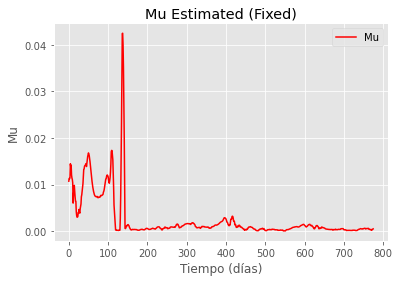

In [24]:
# Mu Fixed Representation

plt.plot(range(0, len(mu_smooth_fix)), mu_smooth_fix, 'r', label="Mu")
plt.xlabel("Tiempo (días)")
plt.ylabel("Mu")
plt.legend()

plt.title("Mu Estimated (Fixed)")

## 7. Creation of the final dataframe

In [25]:
# Arrays which will form the final dataframe
iso_code = df.values[:, 0]
continent = df.values[:, 1]
region = df.values[:, 2]
dates = df.values[:, 3]

iso_code[0:5], continent[0:5], region[0:5], dates[0:5]

(array(['ESP', 'ESP', 'ESP', 'ESP', 'ESP'], dtype=object),
 array(['Europe', 'Europe', 'Europe', 'Europe', 'Europe'], dtype=object),
 array(['Spain', 'Spain', 'Spain', 'Spain', 'Spain'], dtype=object),
 array(['2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31',
        '2020-02-01'], dtype=object))

In [26]:
# Adjusting arrays: 6 last values are lost because LM algorithm, 6 first values are lost when smoothing

iso_code = iso_code[6:len(iso_code)-6]
continent = continent[6:len(continent)-6]
region = region[6:len(region)-6]
dates = dates[6:len(dates)-6]

len(dates), len(region), len(continent), len(iso_code), len(gamma_smooth_fix), len(mu_smooth_fix), len(beta_smooth), len(R0_smooth_gammaMean)

(775, 775, 775, 775, 775, 775, 775, 775)

In [27]:
# Array concatenation for building the final dataframe

columns = 17  # Number of columns
X_total = np.empty((len(beta_smooth), columns), dtype = object)

for i in range(len(beta_smooth)):
    X_total[i] = [iso_code[i], continent[i], region[i], dates[i], mu_fin[i], mu_smooth[i], mu_fixed[i], mu_smooth_fix[i],
                  beta_fin[i], beta_smooth[i], gamma_fin[i], gamma_smooth[i], gamma_raw_fix[i], gamma_smooth_fix[i],
                  R0_raw[i], R0_smooth_constant[i], R0_smooth_gammaMean[i]]
    
X_total.shape, X_total[0:10]

((775, 17),
 array([['ESP', 'Europe', 'Spain', '2020-02-03', 0.01,
         0.010716436218502648, 0.01, 0.010716436218502648, 0.045,
         0.03994075670148489, 0.07142857142857142, 0.039652678845496496,
         0.07142857142857142, 0.042237508052353566, 0.6475376073128947,
         0.5591705938207885, 0.574838134167497],
        ['ESP', 'Europe', 'Spain', '2020-02-04', 0.01,
         0.01130251620815548, 0.01, 0.01130251620815548, 0.045,
         0.047611134324488394, 0.07142857142857142, 0.026831811217170175,
         0.07142857142857142, 0.0320334264197005, 0.6475376073128947,
         0.6665558805428375, 0.6852322760241917],
        ['ESP', 'Europe', 'Spain', '2020-02-05', 0.01,
         0.011208906644777033, 0.01, 0.011208906644777033, 0.045,
         0.05880913621305865, 0.07142857142857142, 0.015204273990672906,
         0.07142857142857142, 0.021829344787047438, 0.6475376073128947,
         0.8233279069828212, 0.8463969369779117],
        ['ESP', 'Europe', 'Spain', '2020-02-

In [28]:
# Labels of each column of the dataframe
labels = ['ISO_code', 'Continent', 'Country/Region', 'Date', 'Mu Raw', 'Mu Smooth (7 days average)', 'Mu Fixed Raw',
          'Mu Fixed Smooth', 'Beta', 'Beta Fixed Smooth', 'Gamma Raw', 'Gamma Smooth (7 days average)',
          'Gamma Fixed', 'Gamma Fixed Smooth', 'R0 Raw', 'R0 Fixed Smooth (Gamma = 1/14)', 'R0 Fixed Smooth (Mean Gamma)']

In [29]:
# Creation of the final dataframe
df_parameters = pd.DataFrame(data=X_total, columns=labels)
df_parameters

,ISO_code,Continent,Country/Region,Date,Mu Raw,Mu Smooth (7 days average),Mu Fixed Raw,Mu Fixed Smooth,Beta,Beta Fixed Smooth,Gamma Raw,Gamma Smooth (7 days average),Gamma Fixed,Gamma Fixed Smooth,R0 Raw,R0 Fixed Smooth (Gamma = 1/14),R0 Fixed Smooth (Mean Gamma)
0,ESP,Europe,Spain,2020-02-03,0.01,0.0107164,0.01,0.0107164,0.045,0.0399408,0.0714286,0.0396527,0.0714286,0.0422375,0.647538,0.559171,0.574838
1,ESP,Europe,Spain,2020-02-04,0.01,0.0113025,0.01,0.0113025,0.045,0.0476111,0.0714286,0.0268318,0.0714286,0.0320334,0.647538,0.666556,0.685232
2,ESP,Europe,Spain,2020-02-05,0.01,0.0112089,0.01,0.0112089,0.045,0.0588091,0.0714286,0.0152043,0.0714286,0.0218293,0.647538,0.823328,0.846397
3,ESP,Europe,Spain,2020-02-06,0.01,0.0115117,0.01,0.0115117,0.045,0.072383,0.0714286,0.00390101,0.0714286,0.0116253,0.647538,1.01336,1.04175
4,ESP,Europe,Spain,2020-02-07,0.00755949,0.0144576,0.00755949,0.0144576,0.0136219,0.0875334,0.00497414,-0.00835511,0.00497414,0.00142118,0.196016,1.22547,1.2598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,ESP,Europe,Spain,2022-03-14,0.00076194,0.000326251,0.00076194,0.000351046,0.0704652,0.0689761,0.0818926,0.081589,0.0818926,0.081589,1.01397,0.965666,0.992723
771,ESP,Europe,Spain,2022-03-15,-6.75971e-05,0.000205747,0,0.000242197,0.0624373,0.0700354,0.0724322,0.0806467,0.0724322,0.0806467,0.898456,0.980496,1.00797
772,ESP,Europe,Spain,2022-03-16,4.43817e-05,0.000282343,4.43817e-05,0.000309136,0.0492686,0.0771561,0.0606418,0.0813184,0.0606418,0.0813184,0.708961,1.08019,1.11045
773,ESP,Europe,Spain,2022-03-17,-0.000103318,0.000415562,0,0.000442356,0.034664,0.0907183,0.0579749,0.0838809,0.0579749,0.0838809,0.498805,1.27006,1.30564


In [30]:
# Export dataframe to a csv file

from pathlib import Path  
filepath = Path('Parameters_LM.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_parameters.to_csv(filepath, index=False)